What is RefFlat?
The RefFlat file is a gene annotation file. Each row represents a transcript and includes information like:

The gene name and transcript name,

The chromosome it's on (chrom),

The strand (+ or -),

Start and end positions of the transcript (tx_start_5prime, tx_start_3prime).

This is crucial for finding Transcription Start Sites (TSS).

In [28]:
import numpy as np
import pandas as pd


ref = pd.read_csv("refFlat", sep="\t", header=None)

ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

ref["tss"] = ref.apply(
    lambda row: row["tx_start_5prime"] if row["strand"] == "+" else row["tx_start_3prime"],
    axis=1
)
tss_table = ref[["chrom", "tss"]].copy()


ref.columns:

 Manually adds column names so we can access each column by a meaningful name.

Most importantly:

"chrom" → the chromosome (e.g., "chr1")

"strand" → strand orientation of the gene (+ or -)

"tx_start_5prime" and "tx_start_3prime" → transcript start/end



ref tss: 

This computes the TSS (Transcription Start Site) for each row.

Genes on the + strand start at tx_start_5prime.

Genes on the - strand start at tx_start_3prime (they're read backward).

The result is stored in a new column called "tss".

tss_table: 

Extracts just the chromosome and TSS position for later use.

We’ll use this to compare our ATAC-seq peaks to known gene start sites.

Basically we loaded a gene annotation file and created a new column that tells us where each gene starts — taking into account whether it’s on the forward or reverse DNA strand.


In [2]:
#just seeing what it looks like
ref.head()

,gene_name,transcript_name,chrom,strand,tx_start_5prime,tx_start_3prime,cds_start,cds_end,exon_count,exon_starts,exon_ends,tss
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5...",59882606
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3...",36136704
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3...",32151147
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294...",166254138
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,",156215926


In [3]:
tss_table.shape

(47382, 2)

In [4]:
#seeing if some values are missing 

tss_table.isna().sum()

chrom    0
tss      0
dtype: int64

In [ ]:
peaks = pd.read_csv("ATAC_high_var.csv")

# Defining peak center
peaks["peak_center"] = peaks["Summit"]

# Keeping minimal amnt of columns for distance task
peaks = peaks[["ImmGenATAC1219.peakID", "chrom", "peak_center"]].copy()


Loads the big ATAC-seq peak dataset into memory.

peak center thing: 
ATAC-seq peaks cover a region (like 200–500 bp), but we usually work with a single position per peak to make comparisons easier.

"Summit" is the highest signal point inside the peak — where accessibility is greatest.

So we define "peak_center" = "Summit".





In [6]:
#just to see if it worked 
peaks.head()


,ImmGenATAC1219.peakID,chrom,peak_center
0,ImmGenATAC1219.peak_69,chr1,4468579
1,ImmGenATAC1219.peak_77,chr1,4490652
2,ImmGenATAC1219.peak_83,chr1,4496479
3,ImmGenATAC1219.peak_84,chr1,4496738
4,ImmGenATAC1219.peak_93,chr1,4547574


In [7]:
peaks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75857 entries, 0 to 75856
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ImmGenATAC1219.peakID  75857 non-null  object
 1   chrom                  75857 non-null  object
 2   peak_center            75857 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Creating dictionary: chrom → sorted array of TSSs on that chromosome
tss_dict = {
    chrom: np.sort(group["tss"].values)
    for chrom, group in tss_table.groupby("chrom")
}


We want to efficiently find the closest TSS for each ATAC peak.
Since a genome has thousands of TSSs, and they’re different on each chromosome, it’s faster to organize them like this:

One dictionary per chromosome → with all the TSS positions on that chromosome.

groupby("chrom")
→ For each chromosome (e.g., "chr1", "chr2"), get all TSS rows.

group["tss"].values
→ Extract just the TSS positions as a NumPy array.

np.sort(...)
→ Sort the TSS positions from smallest to largest.

This lets us later use binary search (super fast).

In [ ]:
# Function to find the nearest TSS to a peak center on the same chromosome

def fast_closest_tss(chrom, center):
    if chrom not in tss_dict:
        return np.nan # no TSS available for this chromosome
    tss_array = tss_dict[chrom]
 
    idx = np.searchsorted(tss_array, center)
  
      # Edge cases: if center is before first or after last TSS
    if idx == 0:
        return tss_array[0]
    elif idx == len(tss_array):
        return tss_array[-1]
    else:
           # Picking the closest of the two surrounding TSS positions
        left = tss_array[idx - 1]
        right = tss_array[idx]
        return left if abs(center - left) < abs(center - right) else right


The first function takes:

chrom: the chromosome the peak is on,

center: the peak’s central position (summit),

And returns:

The closest TSS on that chromosome.

the idx thingys are too long to explain here but basically it enhances the accuracy of everything


In [ ]:
# Applying the closest-TSS function to each row of the peaks table

peaks["closest_tss"] = peaks.apply(
    lambda row: fast_closest_tss(row["chrom"], row["peak_center"]),
    axis=1
)

# Calculating absolute distance between peak center and closest TSS
peaks["distance_to_tss"] = np.abs(peaks["peak_center"] - peaks["closest_tss"])


Subtracts the TSS location from the peak center to get the distance.

In [ ]:

#checking the head of the new columns
peaks[["peak_center", "closest_tss", "distance_to_tss"]].head(10)


,peak_center,closest_tss,distance_to_tss
0,4468579,4497354.0,28775.0
1,4490652,4497354.0,6702.0
2,4496479,4497354.0,875.0
3,4496738,4497354.0,616.0
4,4547574,4497354.0,50220.0
5,4571695,4497354.0,74341.0
6,4571997,4497354.0,74643.0
7,4623471,4497354.0,126117.0
8,4689301,4785726.0,96425.0
9,4747948,4785726.0,37778.0


In [12]:
peaks.head()
peaks.to_csv("peaks_tss_distance.csv", index = False)

In [13]:

print(peaks["distance_to_tss"].min())
print(peaks["distance_to_tss"].max())
print(peaks["distance_to_tss"].mean())


0.0
1352206.0
33294.53036255768


Now just gonna do some filtering

In [14]:
#checking dataset before filtering

print(peaks.shape)


(75857, 5)


In [15]:
#filtering and checking the no after filtering 

filtered = peaks.dropna(subset=["distance_to_tss"])
print(filtered.shape)

#seeing how many dropped
print(peaks.shape[0] - filtered.shape[0])


(75850, 5)
7


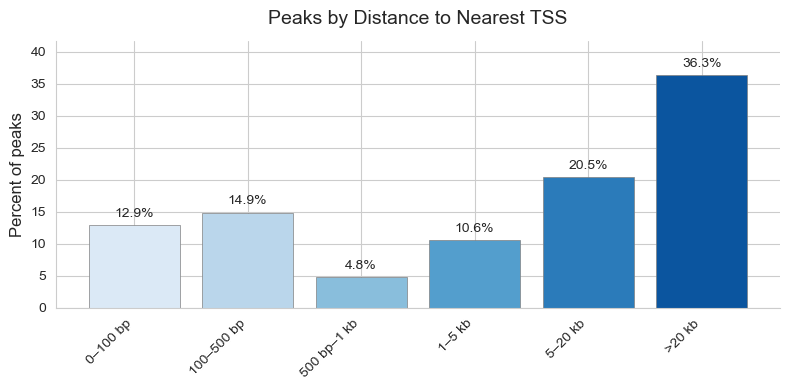

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


d = df["distance_to_tss"].values

bins  = [0, 100, 500, 1_000, 5_000, 20_000, np.inf]
labels = ["0–100 bp","100–500 bp","500 bp–1 kb","1–5 kb","5–20 kb",">20 kb"]

cat    = pd.cut(d, bins=bins, labels=labels, right=False)
counts = cat.value_counts().reindex(labels)
pct    = counts / counts.sum() * 100


sns.set_style("whitegrid")
palette = sns.color_palette("Blues", len(labels))  # smooth blue gradient

fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(
    labels, pct,
    color=palette,
    edgecolor="gray",
    linewidth=0.5
)


for bar, p in zip(bars, pct):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        p + 0.8,
        f"{p:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )


ax.set_ylabel("Percent of peaks", fontsize=12)
ax.set_title("Peaks by Distance to Nearest TSS", fontsize=14, pad=12)
ax.set_ylim(0, pct.max()*1.15)
plt.xticks(rotation=45, ha="right")
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()


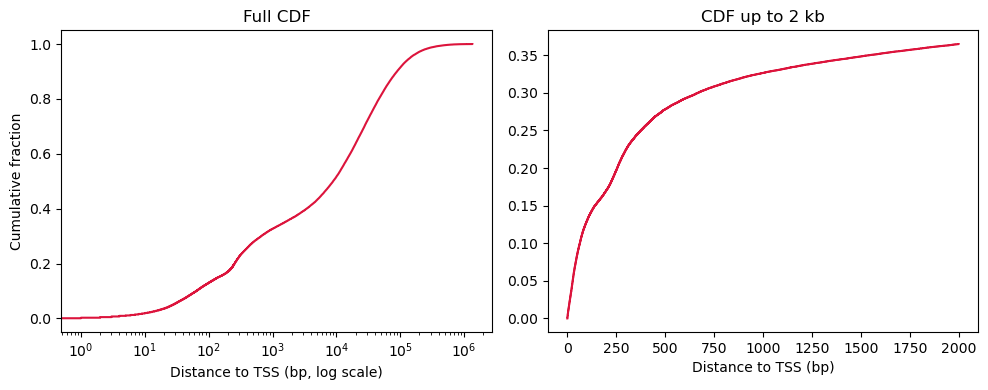

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

d = np.sort(df["distance_to_tss"].values)
cdf = np.arange(1, len(d)+1) / len(d)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))


ax1.step(d, cdf, where="post", color="crimson")
ax1.set_xscale("log")
ax1.set_xlabel("Distance to TSS (bp, log scale)")
ax1.set_ylabel("Cumulative fraction")
ax1.set_title("Full CDF")


mask = d <= 2000
ax2.step(d[mask], cdf[mask], where="post", color="crimson")
ax2.set_xlabel("Distance to TSS (bp)")
ax2.set_title("CDF up to 2 kb")

plt.tight_layout()
plt.show()


Before doing a full scatter plot, we want to understand how peaks are distributed based on how far they are from the closest gene start site (TSS).

This histogram helps us visually check:

Are most peaks near genes?

Do we have lots of distant, intergenic peaks?



Now starting w task 2 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr


dist = pd.read_csv("peaks_tss_distance.csv")  
peaks = pd.read_csv("ATAC_high_var.csv")


peaks = peaks.rename(columns={
    "ImmGenATAC1219.peakID": "peak_ID",
    "Summit":                "peak_center"
})


_meta = {
    "peak_ID","chrom","peak_center",
    "mm10.60way.phastCons_scores","_-log10_bestPvalue",
    "Included.in.systematic.analysis","TSS","genes.within.100Kb","variance"
}
signal_cols = [c for c in peaks.columns if c not in _meta]
peaks["mean_signal"] = peaks[signal_cols].mean(axis=1)


df = dist.rename(columns={"ImmGenATAC1219.peakID":"peak_ID"}).merge(
    peaks[["peak_ID","mean_signal"]],
    on="peak_ID",
    how="inner"
)




/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_22995/3681938626.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby("bin")["mean_signal"] \


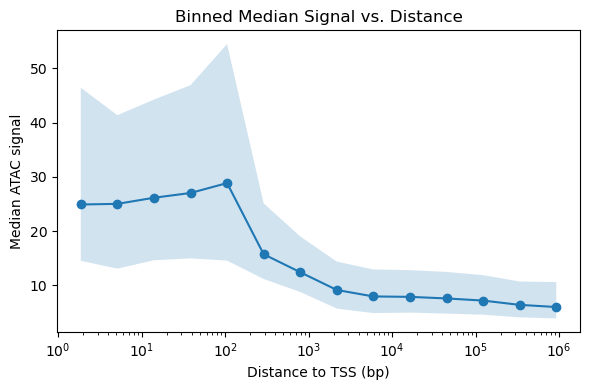

In [ ]:




bins = np.logspace(0, np.log10(df["distance_to_tss"].max()), 15)
df["bin"] = pd.cut(df["distance_to_tss"], bins, right=False)


binned = df.groupby("bin")["mean_signal"] \
           .agg(Median="median", _25th=lambda x: np.percentile(x,25),
                _75th=lambda x: np.percentile(x,75)) \
           .reset_index()


binned["center"] = binned["bin"].apply(lambda iv: (iv.left+iv.right)/2)

plt.figure(figsize=(6,4))
plt.plot(binned["center"], binned["Median"], marker="o", linestyle="-")
plt.fill_between(binned["center"], binned["_25th"], binned["_75th"],
                 alpha=0.2)
plt.xscale("log")
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Median ATAC signal")
plt.title("Binned Median Signal vs. Distance")
plt.tight_layout()
plt.show()


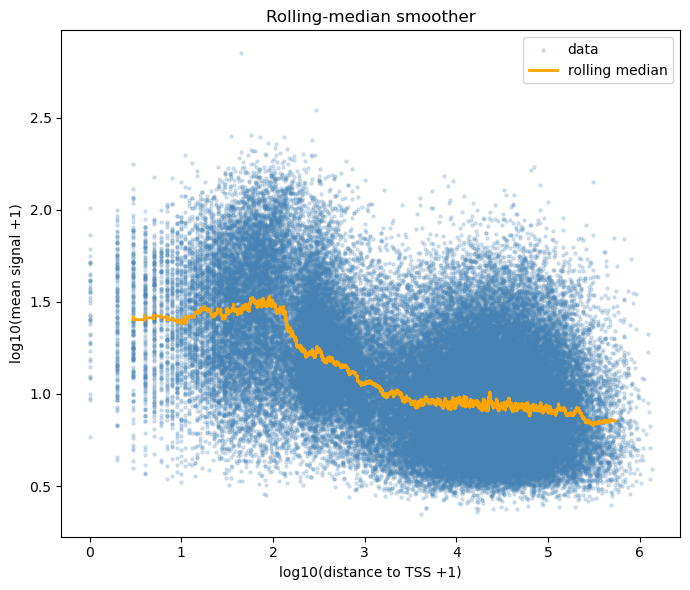

In [ ]:

tmp = df.sort_values("distance_to_tss").copy()
tmp["log_dist"]   = np.log10(tmp["distance_to_tss"] + 1)
tmp["log_signal"] = np.log10(tmp["mean_signal"]     + 1)
tmp["roll_med"]   = tmp["log_signal"].rolling(window=500, center=True).median()

plt.figure(figsize=(7,6))
plt.scatter(tmp["log_dist"], tmp["log_signal"],
            s=5, alpha=0.2, color="steelblue", label="data")
plt.plot(tmp["log_dist"], tmp["roll_med"],
         color="orange", lw=2, label="rolling median")
plt.xlabel("log10(distance to TSS +1)")
plt.ylabel("log10(mean signal +1)")
plt.title("Rolling‐median smoother")
plt.legend()
plt.tight_layout()
plt.show()
